In [116]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import statsmodels.formula.api as smf

import plotly.io as pio
pio.renderers.default = "browser"

In [117]:
# cea_df = pd.read_csv("./data/cea.csv")

cea_df = pd.read_pickle("./data/cea.pkl")
cea_df.head()

,salesperson_name,transaction_date,salesperson_reg_num,property_type,transaction_type,represented,town,district,general_location,date,year,month,year_month,is_buyer_side,is_seller_side,agent_id,period,prepost
0,SOH HUI HUA,OCT-2017,P000003I,HDB,RESALE,SELLER,YISHUN,-,-,2017-10-01,2017,10,2017-10-01,0,1,P000003I,PRE (2017),Pre-Portal
1,SOH HUI HUA,MAR-2018,P000003I,HDB,RESALE,BUYER,KALLANG/WHAMPOA,-,-,2018-03-01,2018,3,2018-03-01,1,0,P000003I,POST (2018+),Post-Portal
2,SOH HUI HUA,JAN-2017,P000003I,HDB,RESALE,BUYER,YISHUN,-,-,2017-01-01,2017,1,2017-01-01,1,0,P000003I,PRE (2017),Pre-Portal
3,SOH HUI HUA,MAY-2018,P000003I,HDB,RESALE,SELLER,CHOA CHU KANG,-,-,2018-05-01,2018,5,2018-05-01,0,1,P000003I,POST (2018+),Post-Portal
4,SOH HUI HUA,NOV-2017,P000003I,HDB,RESALE,SELLER,CHOA CHU KANG,-,-,2017-11-01,2017,11,2017-11-01,0,1,P000003I,PRE (2017),Pre-Portal


In [66]:
def parse_month_year(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.strip().str.upper()
    return pd.to_datetime(s, format="%b-%Y", errors="coerce")

cea_df = cea_df.copy()

for col in ["property_type", "transaction_type", "represented", "town"]:
    if col in cea_df.columns:
        cea_df[col] = cea_df[col].astype(str).str.strip().str.upper()

cea_df["date"] = parse_month_year(cea_df["transaction_date"])
cea_df = cea_df[cea_df["date"].notna()].copy()
cea_df["month"] = cea_df["date"].dt.month
cea_df["year"] = cea_df["date"].dt.year

cea_df.head()

,salesperson_name,transaction_date,salesperson_reg_num,property_type,transaction_type,represented,town,district,general_location,date,month,year
0,SOH HUI HUA,OCT-2017,P000003I,HDB,RESALE,SELLER,YISHUN,-,-,2017-10-01,10,2017
1,SOH HUI HUA,MAR-2018,P000003I,HDB,RESALE,BUYER,KALLANG/WHAMPOA,-,-,2018-03-01,3,2018
2,SOH HUI HUA,JAN-2017,P000003I,HDB,RESALE,BUYER,YISHUN,-,-,2017-01-01,1,2017
3,SOH HUI HUA,MAY-2018,P000003I,HDB,RESALE,SELLER,CHOA CHU KANG,-,-,2018-05-01,5,2018
4,SOH HUI HUA,NOV-2017,P000003I,HDB,RESALE,SELLER,CHOA CHU KANG,-,-,2017-11-01,11,2017


In [67]:
portal_launch = pd.Timestamp("2018-01-01")
cea_df["portal_launch"] = (cea_df["date"] >= portal_launch).astype(int)

# Agent ID
cea_df["agent_id"] = cea_df["salesperson_reg_num"].astype(str).str.strip().str.upper()

# Useful binary flags
cea_df["buyer"] = (cea_df["represented"] == "BUYER").astype(int)
cea_df["seller"] = (cea_df["represented"] == "SELLER").astype(int)
cea_df["is_resale"] = (cea_df["transaction_type"] == "RESALE").astype(int)

In [69]:
df_resale = cea_df[cea_df["is_resale"].eq(1)].copy()

panel_bs = (
    df_resale
    .groupby(["date", "buyer"], as_index=False)
    .size()
    .rename(columns={"size": "agent_sides"})
)

panel_bs["post"] = (panel_bs["date"] >= portal_launch).astype(int)
panel_bs["did"] = panel_bs["post"] * panel_bs["buyer"]
panel_bs["log_sides"] = np.log1p(panel_bs["agent_sides"])

panel_bs.head()

,date,buyer,agent_sides,post,did,log_sides
0,2017-01-01,0,1400,0,0,7.244942
1,2017-01-01,1,1053,0,0,6.960348
2,2017-02-01,0,1510,0,0,7.320527
3,2017-02-01,1,1086,0,0,6.991177
4,2017-03-01,0,1375,0,0,7.226936


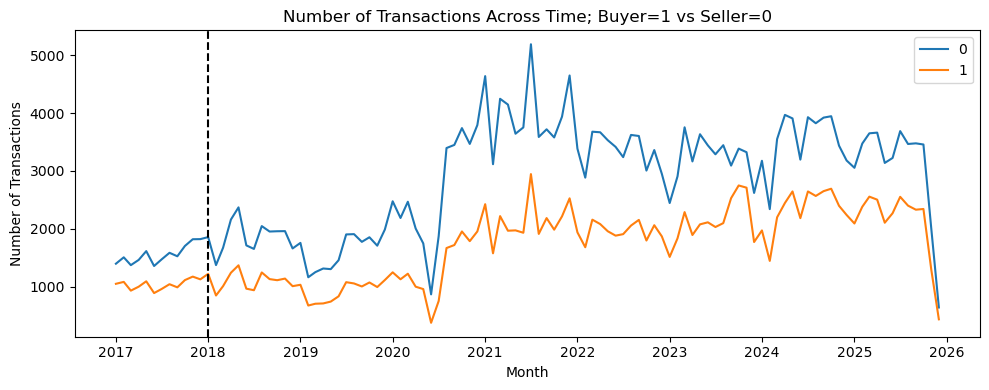

In [87]:
def plot_group_trends(
    panel,
    group_col,
    value_col="agent_sides",
    title="",
    vline=portal_launch,
    figsize=(12, 4)   # width, height in inches
):
    plt.figure(figsize=figsize)

    for g, sub in panel.groupby(group_col):
        plt.plot(sub["date"], sub[value_col], label=str(g))

    plt.axvline(vline, linestyle="--", color="black")
    plt.title(title)
    plt.xlabel("Month")
    plt.ylabel("Number of Transactions")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_group_trends(panel_bs, "buyer", title="Number of Transactions Across Time; Buyer=1 vs Seller=0",figsize=(10, 4))


In [53]:
m1 = smf.ols(
    "agent_sides ~ post + buyer + post:buyer",
    data=panel_bs
).fit(cov_type="HC1")
print("\n=== DiD #1 (Buyer vs Seller, resale only): BASIC ===")
print(m1.summary())


=== DiD #1 (Buyer vs Seller, resale only): BASIC ===
                            OLS Regression Results                            
Dep. Variable:            agent_sides   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     157.4
Date:                Sat, 10 Jan 2026   Prob (F-statistic):           1.12e-53
Time:                        23:41:00   Log-Likelihood:                -1739.1
No. Observations:                 216   AIC:                             3486.
Df Residuals:                     212   BIC:                             3500.
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

In [78]:
panel_bs = panel_bs.sort_values("date").copy()
panel_bs["t"] = (panel_bs["date"] - panel_bs["date"].min()).dt.days
panel_bs["month"] = panel_bs["date"].dt.month

m1_fe = smf.ols(
    "agent_sides ~ post + buyer + post:buyer + C(month) + t",
    data=panel_bs
).fit(cov_type="HC1")
print("\n=== DiD #1: + Month FE + linear time trend ===")
print(m1_fe.summary())


=== DiD #1: + Month FE + linear time trend ===
                            OLS Regression Results                            
Dep. Variable:            agent_sides   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     51.14
Date:                Sun, 11 Jan 2026   Prob (F-statistic):           5.46e-60
Time:                        09:29:11   Log-Likelihood:                -1682.5
No. Observations:                 216   AIC:                             3397.
Df Residuals:                     200   BIC:                             3451.
Df Model:                          15                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------

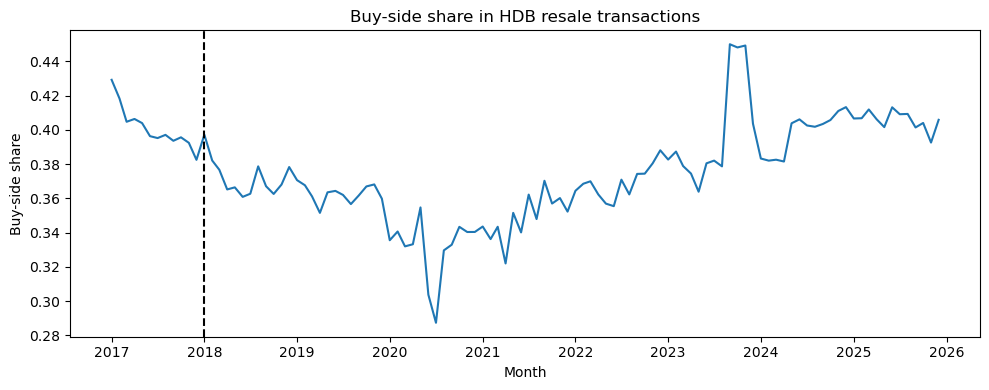

In [ ]:
buyer_share = (
    cea_df[cea_df["transaction_type"] == "RESALE"]
    .groupby(["date", "represented"])
    .size()
    .rename("agent_sides")
    .reset_index()
    .pivot(index="date", columns="represented", values="agent_sides")
    .fillna(0)
    .reset_index()
)

buyer_share["buyer_share"] = (
    buyer_share["BUYER"] /
    (buyer_share["BUYER"] + buyer_share["SELLER"])
)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(buyer_share["date"], buyer_share["buyer_share"])
plt.axvline(pd.Timestamp("2018-01-01"), linestyle="--", color="black")
plt.title("Buy-side share in HDB resale transactions")
plt.ylabel("Buy-side share")
plt.xlabel("Month")
plt.tight_layout()
plt.show()

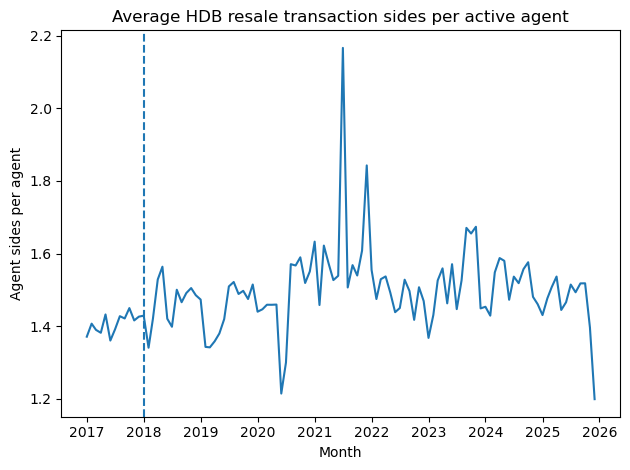

In [ ]:
resale = cea_df[cea_df["transaction_type"] == "RESALE"].copy()

monthly_prod = (
    resale.groupby("date")
    .agg(
        agent_sides=("salesperson_reg_num", "size"),
        active_agents=("salesperson_reg_num", "nunique")
    )
    .reset_index()
)

monthly_prod["sides_per_agent"] = (
    monthly_prod["agent_sides"] / monthly_prod["active_agents"]
)

plt.figure()
plt.plot(monthly_prod["date"], monthly_prod["sides_per_agent"])
plt.axvline(pd.Timestamp("2018-01-01"), linestyle="--")
plt.title("Average HDB resale transaction sides per active agent")
plt.ylabel("Agent sides per agent")
plt.xlabel("Month")
plt.tight_layout()
plt.show()

In [ ]:
resale["period"] = resale["date"].apply(
    lambda x: "Pre-2018" if x < pd.Timestamp("2018-01-01") else "Post-2018"
)

agent_roles = (
    resale.groupby(["salesperson_reg_num", "period", "represented"])
    .size()
    .rename("sides")
    .reset_index()
    .pivot(index=["salesperson_reg_num", "period"],
           columns="represented",
           values="sides")
    .fillna(0)
    .reset_index()
)

agent_roles["buyer_share"] = (
    agent_roles["BUYER"] /
    (agent_roles["BUYER"] + agent_roles["SELLER"])
)

role_shift = (
    agent_roles.groupby("period")["buyer_share"]
    .mean()
    .reset_index()
)

print(role_shift)

      period  buyer_share
0  Post-2018     0.383621
1   Pre-2018     0.415399


In [108]:
agents_pre = set(
    resale[resale["date"] < pd.Timestamp("2018-01-01")]["salesperson_reg_num"]
)

agents_post = set(
    resale[resale["date"] >= pd.Timestamp("2018-01-01")]["salesperson_reg_num"]
)

exit_agents = agents_pre - agents_post

print("Agents active pre-2018:", len(agents_pre))
print("Agents still active post-2018:", len(agents_pre & agents_post))
print("Agents who exited after 2018:", len(exit_agents))

Agents active pre-2018: 8673
Agents still active post-2018: 7884
Agents who exited after 2018: 789
